***
## <center>LBM flow visualisation around Cylinder</center> 
#### <center> Student. Benhari Abdessalam -- Mines Paristech - February 2021 </center>
***
### > The approach :
___

To be able to parallelise the LBM code given below, we tried to analyse it and understand it first, this lead us to devide it into multiple sections, some that can be parallelised and some that can not (usually require a global syncronisation (_like the stream part_), which is very hard to achieve using one kernel and multiple thread blocks). We then tried to implement each section differently in order for it to fit the _CUDA_ requirements. Then we defined the size of our thread blocks and the number of threads in each one (which can be changed of course). Finally we tried to fine tune our code by merging the sections that could be parallelised to avoid any unnecessary syncronisation. We also minimised the data transfer between the _host_ and the _device_ by using local variables.

In [1]:
# Libraries importation
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from numba import cuda
from numba import prange
from numba.cuda import device_array
import numba
import math

### > State & Variables definition  :
---
- #### Flow State:

In [2]:
maxIter = 20000  # Total number of time iterations.
Re = 150.0         # Reynolds number.
nx, ny = 420, 180 # Numer of lattice nodes.
ly = ny-1         # Height of the domain in lattice units.
cx, cy, r = nx//4, ny//2, ny//9 # Coordinates of the cylinder.
uLB     = 0.04                  # Velocity in lattice units.
nulb    = uLB*r/Re;             # Viscoscity in lattice units.
omega = 1 / (3*nulb+0.5);    # Relaxation parameter.

- #### Lattice Constants:

In [3]:
v = np.array([ [ 1,  1], [ 1,  0], [ 1, -1], [ 0,  1], [ 0,  0],
               [ 0, -1], [-1,  1], [-1,  0], [-1, -1] ])
v_g = cuda.to_device(v)

t = np.array([ 1/36, 1/9, 1/36, 1/9, 4/9, 1/9, 1/36, 1/9, 1/36])
t_g = cuda.to_device(t)
col1 = np.array([0, 1, 2])
col2 = np.array([3, 4, 5])
col3 = np.array([6, 7, 8])

- #### Cuda Parameters (threads/blocks):

In [4]:
threadsperblock = (16, 16)
blockspergrid_x = math.ceil(nx / threadsperblock[0])
blockspergrid_y = math.ceil(ny / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

### > Functions initiation  :
---
- #### First flow state with initial velocity:

In [5]:
@cuda.jit
def equilibrium(rho, feq):
    """Equilibrium distribution function.
    """
    j, k = cuda.grid(2)
    if j < nx and k < ny :
        # initial velocity field
        u_0 = uLB * (1 + 1e-4*math.sin(k/ly*2*math.pi))
        u_1 = 0
        for i in range(9):
            cu = 3 * (v[i,0]*u_0 + v[i,1]*u_1)
            feq[i,j,k] = rho * t[i] * (1 + cu + 0.5*cu**2 - 3/2 * (u_0**2 + u_1**2))

- #### Pre-stream operations (highly parallelised):

In [6]:
@cuda.jit
def pre_stream(fin, fout, u, v, t, time):
    j, k = cuda.grid(2)
    if j<nx and k<ny:
        # Set a local array for inside calculations
        feq = cuda.local.array(9, dtype=numba.float64)
        
        # Create obstacle mask array from element-wise function
        obstacle = int(((j-cx)**2+(k-cy)**2)< (r**2))
        
        # Right wall: outflow condition.
        # we only need here to specify distrib. function for velocities
        # that enter the domain (other that go out, are set by the streaming step)
        if j==(nx-1):
            for i in col3:
                fin[i,j,k] = fin[i,j-1, k] 

        # Compute macroscopic variables, density and velocity.
        # (using local variables)
        rho = 0    
        u_0 = 0
        u_1 = 0
        for i in range(9):
            rho += fin[i,j,k]    
            u_0 += v[i,0] * fin[i,j,k]
            u_1 += v[i,1] * fin[i,j,k]
        u_0 /= rho
        u_1 /= rho
        
        # Left wall: inflow condition.
        if j == 0:
            rho = 0
            u_0 = uLB * (1 + 1e-4*math.sin(k/ly*2*math.pi)) #  vel_0 (initial velocity fields)
            u_1 = 0 # vel_1
            for i_1, i_2 in zip(col2, col3):
                rho+= fin[i_1,j,k] + 2*fin[i_2,j,k]
            rho *= 1/(1-u_0)
        
        # Compute equilibrium.
        for i in range(9):
            cu = 3 * (v[i,0]*u_0 + v[i,1]*u_1)
            feq[i] = rho * t[i] * (1 + cu + 0.5*cu**2 - 3/2 * (u_0**2 + u_1**2))
        if j == 0 :
            for i in range(3):
                fin[i,j,k] = feq[i] + fin[8-i,j,k] - feq[8-i]
                
        # collision step.
        for i in range(9):
            fout[i, j, k] = fin[i, j, k] - omega * (fin[i, j, k] - feq[i])
            
        # Bounce-back condition for obstacle.
        if obstacle:
            for i in range(9):
                fout[i, j, k] = fin[8-i, j, k]
                
        # Final velocity update.
        if time == maxIter-1:
            u[0, j, k] = u_0
            u[1, j, k] = u_1

- #### Streaming function:

In [7]:
@cuda.jit
def stream(fin, fout, v):
    j, k = cuda.grid(2)
    if j<nx and k<ny:
        for i in range(9):
                fin[i, j, k] = fout[i, (j-v[i, 0]) % nx, (k-v[i, 1]) % ny]

### > Main Script  :
---

In [8]:
def main():
    # f values initialization
    fin = np.zeros((9,nx,ny))
    fin_g = cuda.to_device(fin)
    fout = np.zeros((9,nx,ny))
    fout_g = cuda.to_device(fout)
    
    # where to store the final velocity values
    u = np.zeros((2,nx,ny))
    u_g = cuda.to_device(u)
    # Initialization of the populations at equilibrium 
    # with the given velocity.
    equilibrium[blockspergrid, threadsperblock](1, fin_g)
    
    ###### Main time loop ########
    for time in range(maxIter):
        
        # Pre-streaming step.
        pre_stream[blockspergrid, threadsperblock](fin_g, fout_g, u_g, v_g, t_g, time)

        # Streaming step.
        stream[blockspergrid, threadsperblock](fin_g, fout_g, v_g) 
 
    # Visualization of the velocity (on final step).
    u = u_g.copy_to_host()
    plt.clf()
    plt.imshow(np.sqrt(u[0]**2+u[1]**2).transpose(), cmap=cm.Reds)
    plt.title("LBM flow on Cylinder")
    #plt.savefig("vel.{0:04d}.png".format(time//100))

### > Serial code :
___

In [9]:
###### Function Definitions ############################################
def macroscopic(fin):
    """Compute macroscopic variables (density, velocity)

    fluid density is 0th moment of distribution functions 
    fluid velocity components are 1st order moments of dist. functions
    """
    rho = np.sum(fin, axis=0)
    u = np.zeros((2, nx, ny))
    for i in range(9):
        u[0,:,:] += v[i,0] * fin[i,:,:]
        u[1,:,:] += v[i,1] * fin[i,:,:]
    u /= rho
    return rho, u

def equilibrium_s(rho, u):
    """Equilibrium distribution function.
    """
    usqr = 3/2 * (u[0]**2 + u[1]**2)
    feq = np.zeros((9,nx,ny))
    for i in range(9):
        cu = 3 * (v[i,0]*u[0,:,:] + v[i,1]*u[1,:,:])
        feq[i,:,:] = rho*t[i] * (1 + cu + 0.5*cu**2 - usqr)
    return feq

#
# Setup: cylindrical obstacle and velocity inlet with perturbation
#
# Creation of a mask with boolean values, defining the shape of the obstacle.
#
def obstacle_fun(x, y):
    return (x-cx)**2+(y-cy)**2<r**2

# Initial velocity profile: 
# almost zero, with a slight perturbation to trigger the instability.
def inivel(d, x, y):
    return (1-d) * uLB * (1 + 1e-4*np.sin(y/ly*2*np.pi))

#############################################################
def serial_main():

    # create obstacle mask array from element-wise function
    obstacle = np.fromfunction(obstacle_fun, (nx,ny))

    # initial velocity field vx,vy from element-wise function
    # vel is also used for inflow border condition
    vel = np.fromfunction(inivel, (2,nx,ny))

    # Initialization of the populations at equilibrium 
    # with the given velocity.
    fin = equilibrium_s(1, vel)

    ###### Main time loop ########
    for time in range(maxIter):

        # Right wall: outflow condition.
        # we only need here to specify distrib. function for velocities
        # that enter the domain (other that go out, are set by the streaming step)
        fin[col3,nx-1,:] = fin[col3,nx-2,:] 

        # Compute macroscopic variables, density and velocity.
        rho, u = macroscopic(fin)

        # Left wall: inflow condition.
        u[:,0,:] = vel[:,0,:]
        rho[0,:] = 1/(1-u[0,0,:]) * ( np.sum(fin[col2,0,:], axis=0) +
                                      2*np.sum(fin[col3,0,:], axis=0) )
        
        # Compute equilibrium.
        feq = equilibrium_s(rho, u)
        fin[[0,1,2],0,:] = feq[[0,1,2],0,:] + fin[[8,7,6],0,:] - feq[[8,7,6],0,:]

        # Collision step.
        fout = fin - omega * (fin - feq)

        # Bounce-back condition for obstacle.
        # in python language, we "slice" fout by obstacle
        for i in range(9):
            fout[i, obstacle] = fin[8-i, obstacle]

        # Streaming step.
        for i in range(9):
            fin[i,:,:] = np.roll(np.roll(fout[i,:,:], v[i,0], axis=0),
                                 v[i,1], axis=1 )
 
        # Visualization of the velocity.
        if (time%100==0):
            plt.clf()
            plt.imshow(np.sqrt(u[0]**2+u[1]**2).transpose(), cmap=cm.Reds)


### > Results & Comparison :
---

Parallel time & Result : 



UsageError: Line magic function `%#timeit` not found.


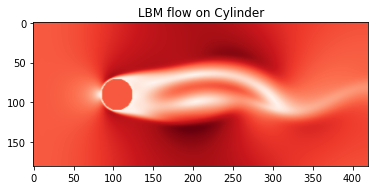

In [10]:
if __name__ == "__main__":
    # execute only if run as a script
    print("Parallel time & Result : \n")
    %timeit main()
    print("\nSerial time & Result : \n")
    %timeit serial_main()

Based on the results above, we clearly did speed up the execution (<b>x32 times faster!</b>), even though it isn t optimal, probably due to the data transfer and the syncronisation that is required on each loop iteration.